In [ ]:
import numpy as np
import itertools
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2', font_scale=1.3)

from dateutil.parser import parse
from tqdm.auto import tqdm

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint
from statsmodels.tsa.seasonal import seasonal_decompose, STL

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from gplearn.genetic import SymbolicRegressor
from tbats import TBATS, BATS
from fbprophet import Prophet
from pmdarima import auto_arima

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

## Prophet, TBATS, SARIMAX модели для предсказания временных рядов

### 1. Задача

Рассмотрим [датасет](https://www.kaggle.com/c/demand-forecasting-kernels-only/overview) с kaggle соревнования по прогнозированию спроса на товары.

In [ ]:
data = pd.read_csv('demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Как мы видим, датасет содержит информацию о магазинах, товарах и продажах. Выберем первый магазин и первый товар и будем предсказывать спрос на выбранный товар в данном магазине, используя последний год для сравнения моделей.

Выделим соотвествущие данные из датасета.

In [ ]:
# Задаем магазин и продукт
store, item = 1, 1

# Выделяем только те данные, которые относятся к данному магазину и продукту
data = data[(data['store'] == store) & (data['item'] == item)]

# Дату уставнавливаем как индекс
data = data.set_index('date')

# Выделяем данные о продажах
data = data['sales']

### 2. Данные
Разделим данные на трейн и тест для обучения и тестирования результатов соотвественно. На тест отправляем данные за последний год.

In [ ]:
test_size = 365
data_train = data.iloc[: -test_size]
data_test  = data.iloc[-test_size:]

Визуализируем полученные данные. Визуализировать данные нужно с самого начала. Это помогает провалидировать данные и выделить некоторые закономерности.

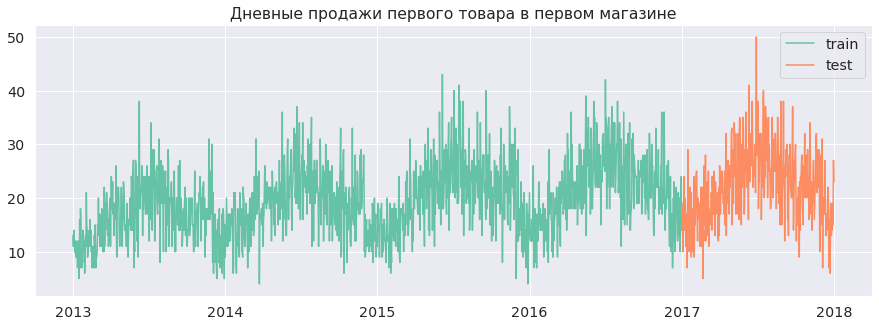

In [ ]:
plt.figure(figsize=(15, 5))
plt.title('Дневные продажи первого товара в первом магазине')
plt.plot(data_train, label='train')
plt.plot(data_test, label='test')
plt.legend();

Видно, что данные обладают годичной сезонностью. Посмотрим теперь, есть ли недельная сезонность.

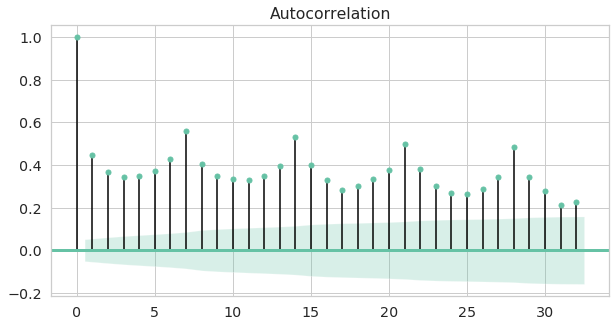

In [ ]:
rcParams['figure.figsize'] = 10, 5
with sns.axes_style('whitegrid'):
    statsmodels.graphics.tsaplots.plot_acf(data_train, lw=3)

Некоторая недельная сезонность присутсвует.

### 3. Метрики
Теперь веренмся к самой задаче. Прежде чем ее решать, зададим метрики по которым мы будем определять, какая из моделей лучше: MSE, MAE, MAPE. Напишем функцию, которая будет считать качество моеделей.

In [ ]:
compare_table = None


def add_results_in_comparison_table(method: str, y_true, y_forecast) -> pd.DataFrame:
    """
    Добавляет новую строчку в таблицу compare_table с результатами текущей модели.
    Если ранее модель была уже добавлена в таблицу, то старая строчка перезапишется на новую.
    
    Параметры:
    - method: имя модели.
    - y_true: истинные значения.
    - y_forecast: предсказанные значения.
    """
    
    # Обращаемся к глобальной переменной
    global compare_table
    
    # Считаем метрики
    result_row = {
        'method': method,
        "MSE": mean_squared_error(y_true=y_true, y_pred=y_forecast),
        "MAE": mean_absolute_error(y_true=y_true, y_pred=y_forecast),
        "MAPE": mean_absolute_percentage_error(y_true=y_true, y_pred=y_forecast)
    }
    
    # Записываем результат в таблицу
    if compare_table is None:
        compare_table = pd.DataFrame([result_row])
    else:
        if method in list(compare_table['method']):
            compare_table = compare_table[compare_table['method'] != method]

        compare_table = pd.concat([compare_table, pd.DataFrame([result_row])])
        compare_table.index = np.arange(len(compare_table))
    return compare_table


def mean_absolute_percentage_error(y_true, y_pred) -> float: 
    """Считает MAPE для y_true и y_pred"""
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### 4. Prophet

Prophet – модель разработанная Facebook для предсказания временных рядов. 


`class` <a href="https://facebook.github.io/prophet/docs/quick_start.html#python-api">`fbprophet.Prophet`</a>`(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)`

Параметры:

* `growth` &mdash;'linear' или 'logistic';
* `changepoints` &mdash; точки изменения поведения временного ряда, которые пользователь задал самостоятельно;
* `n_changepoints` &mdash; максимальное количество точек изменения поведения временного ряда;
* `yearly_seasonality` &mdash; период годовой сезонности, но модель умеет по умолчанию его определять;
* `weekly_seasonality` &mdash; период недельной сезонности, но модель умеет по умолчанию его определять;
* `daily_seasonality` &mdash; период дневной сезонности, но модель умеет по умолчанию его определять;
* `holidays` &mdash; `pd.DataFrame` с колонками `holiday` и `ds` (дата);
* `seasonality_mode` &mdash; 'additive' или 'multiplicative';
* `interval_width` &mdash; ширина доверительного интервала. **По умолчанию равна 0.8**, а не 0.95.

Для начала подготовим данные, чтобы их можно было передать модели.

Модель для обучения принимает на вход датасет из 2 колонок: 
* `ds` &mdash; дата
* `y` &mdash; временой ряд

In [ ]:
prophet_train_df = pd.DataFrame(data_train)
prophet_train_df.columns = ['y']
prophet_train_df['ds'] = prophet_train_df.index

Обучим модель:

In [ ]:
prophet_model = Prophet(interval_width=0.95)
prophet_model.fit(prophet_train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Теперь посмотрим, как делать предсказания с Prophet.

у модели есть удобная функция `make_future_dataframe`, которая сама создает датасет с датами на `periods` моментов вперед, а потом модель принимает этот датасет на вход для предсказания.

In [ ]:
future = prophet_model.make_future_dataframe(
    periods=365, include_history=False
)
y_prophet_forecast = prophet_model.predict(future)

Посмотрим, что выдает модель:

In [ ]:
y_prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,22.656240,12.236519,29.999460,22.656240,22.656240,-1.504870,-1.504870,-1.504870,3.724358,3.724358,3.724358,-5.229228,-5.229228,-5.229228,0.0,0.0,0.0,21.151370
1,2017-01-02,22.660290,4.880803,21.849564,22.660290,22.660290,-9.439790,-9.439790,-9.439790,-4.233537,-4.233537,-4.233537,-5.206253,-5.206253,-5.206253,0.0,0.0,0.0,13.220500
2,2017-01-03,22.664340,7.475811,24.512735,22.664340,22.664340,-6.836648,-6.836648,-6.836648,-1.636270,-1.636270,-1.636270,-5.200378,-5.200378,-5.200378,0.0,0.0,0.0,15.827692
3,2017-01-04,22.668391,8.302788,25.012154,22.668378,22.668399,-6.325192,-6.325192,-6.325192,-1.114675,-1.114675,-1.114675,-5.210518,-5.210518,-5.210518,0.0,0.0,0.0,16.343198
4,2017-01-05,22.672441,8.294942,24.951949,22.672404,22.672473,-5.943023,-5.943023,-5.943023,-0.707908,-0.707908,-0.707908,-5.235115,-5.235115,-5.235115,0.0,0.0,0.0,16.729418


Модель для каждой даты раскладвыает свое предсказание на компоненты.

Из важного:

* `yhat` &mdash; предсказание модели. Предсказательный интервал: ```[yhat_lower, yhat_upper]```.
* `trend` &mdash; значение тренда. Кроме того, модель умеет строить доверительный интервал для него: ```[trend_lower, trend_upper]```.
* `weekly` &mdash; значения сезонности по неделе. `[weekly_lower, weekly_upper]` &mdash; доверительный интервал.
* `yearly` &mdash; значения сезонности по году. `[yearly_lower, yearly_upper]` &mdash; доверительный интервал.


Посмотрим теперь, как модель раскладывает временной ряд на компоненты:

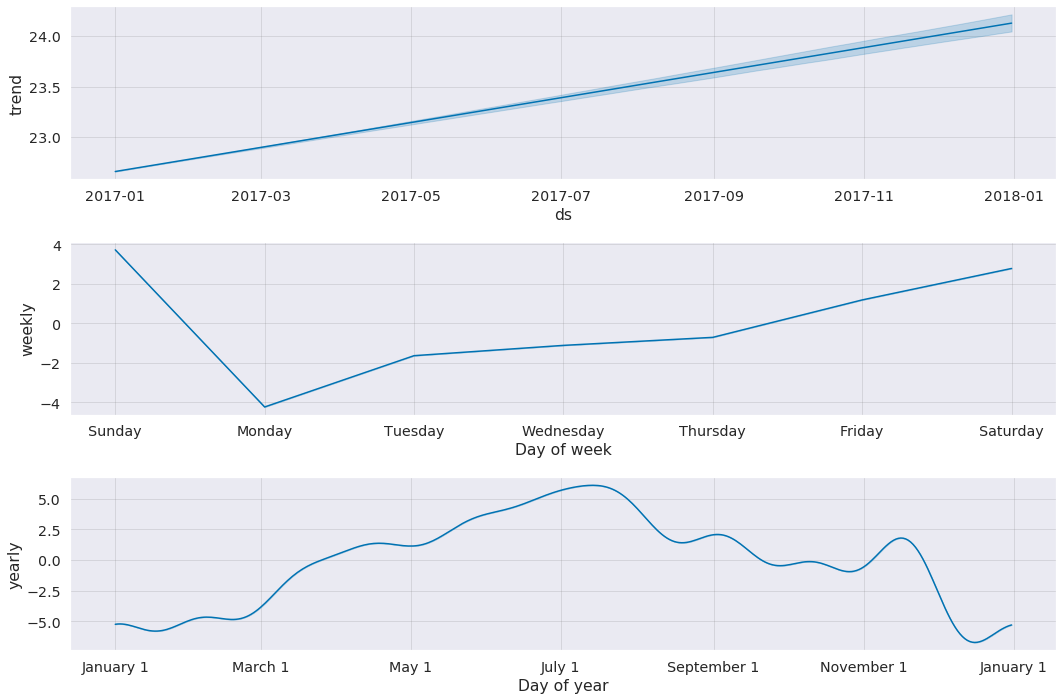

In [ ]:
prophet_model.plot_components(y_prophet_forecast, figsize=(15, 10))
plt.show()

Отсюда можно делать выводы, что:
* тренд на товар положительный;
* меньше всего этот товар покупают в понедельник, больше всего &mdash; в выходные;
* летом товар пользуется наибольшим спросом, а зимой &mdash; наименьшим.


Отобразим полученные результаты.

In [ ]:
def plot_results(y_to_train, y_to_test, y_forecast, plot_conf_int=True,
                 left_bound=None, right_bound=None):
    """
        Функция для визуализации временного ряда и предсказания.
        
        Параметры:
            - y_to_train: pd.Series
                Временной ряд, на котором обучалась модель.
            - y_to_test: pd.Series
                Временной ряд, который предсказывает модель.
            - y_forecast: array
                Предсказания модели.
            - plot_conf_int: bool 
                Надо ли строить предсказательного интервал.
            - left_bound: array
                Левая граница предсказательного интервала.
            - right_bound: array
                Правая граница предсказательного интервала.
    """

    plt.figure(figsize=(15, 5))
    plt.title('Дневные продажи объекта 1 в магазине 1', fontsize=15)
    plt.plot(y_to_train, label='train')
    plt.plot(y_to_test, label='test')
    plt.plot(y_to_test.index, y_forecast, label='prediction')
    if plot_conf_int:
        plt.fill_between(y_to_test.index, 
                         left_bound, right_bound, 
                         alpha=0.3, color='grey',
                         label='conf.int')
    plt.legend()
    plt.show()

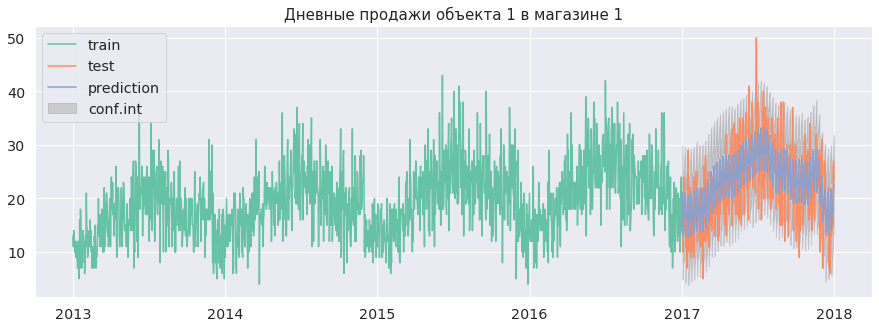

In [ ]:
plot_results(data_train, data_test, y_prophet_forecast['yhat'], plot_conf_int=True,
             left_bound=y_prophet_forecast['yhat_lower'],
             right_bound=y_prophet_forecast['yhat_upper'])

In [ ]:
add_results_in_comparison_table('Prophet', data_test, y_prophet_forecast['yhat'])

,method,MSE,MAE,MAPE
0,Prophet,24.682585,4.032309,22.235187


---

Добавим в модель праздники и посмотрим на предсказаниия.

In [ ]:
prophet_model_with_holidays = Prophet(interval_width=0.95)
prophet_model_with_holidays.add_country_holidays(country_name='US')
prophet_model_with_holidays.fit(prophet_train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Мы добавили 10 федеральных праздников США.

In [ ]:
prophet_model_with_holidays.train_holiday_names

0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10       Christmas Day (Observed)
11    Independence Day (Observed)
dtype: object

Из графиков ниже мы можем заметить, что товар реже покупали во время дня памяти и лучше во время дня независимости.

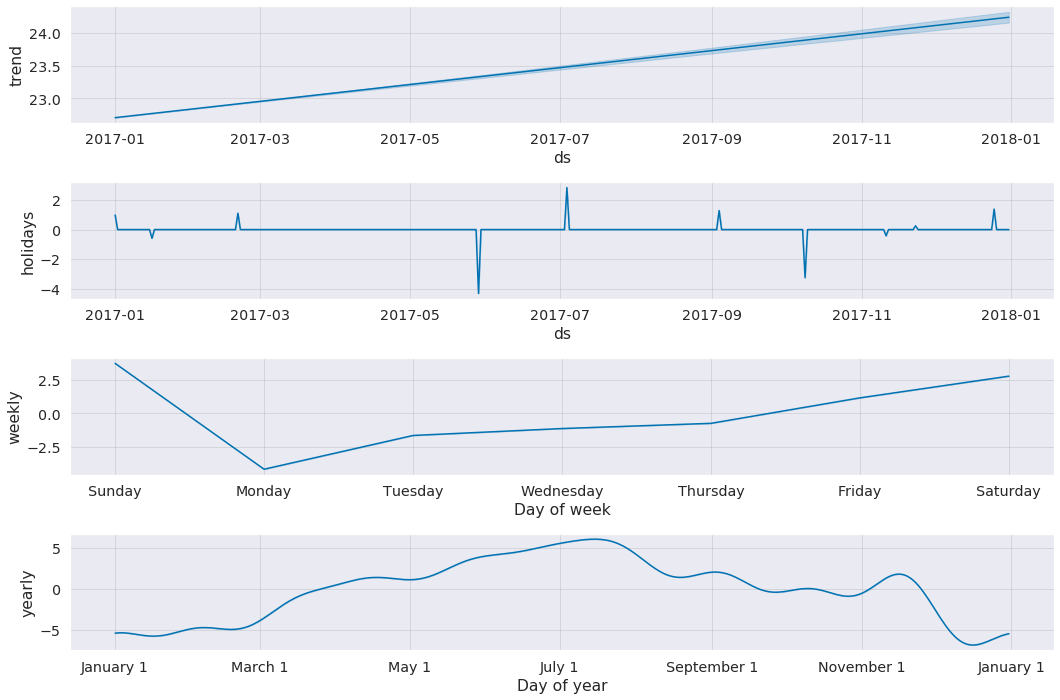

In [ ]:
future = prophet_model_with_holidays.make_future_dataframe(
    periods=365, include_history=False
)
y_prophet_with_holidays_forecast = prophet_model_with_holidays.predict(future)
prophet_model_with_holidays.plot_components(y_prophet_with_holidays_forecast, figsize=(15, 10))
plt.show()

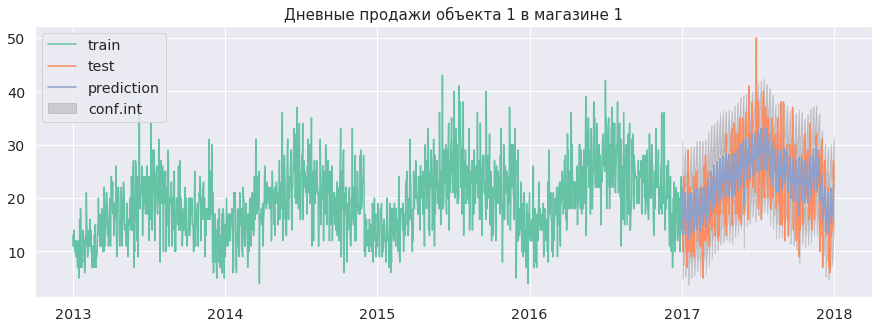

In [ ]:
plot_results(data_train, data_test, y_prophet_with_holidays_forecast['yhat'], 
             plot_conf_int=True,
             left_bound=y_prophet_with_holidays_forecast['yhat_lower'],
             right_bound=y_prophet_with_holidays_forecast['yhat_upper'])

In [ ]:
add_results_in_comparison_table('Prophet + holidays', data_test, y_prophet_with_holidays_forecast['yhat'])

,method,MSE,MAE,MAPE
0,Prophet,24.682585,4.032309,22.235187
1,Prophet + holidays,25.090789,4.074780,22.537087


Добавление праздников не улучшило качество модели.

---

Правда ли, что предсказательный интервал у модели корректен и только $\leq 5\%$ значений не попадают в интервал?

Давайте проверим какой процент от тестовых значений лежит вне доверительного интервала, то есть посчитаем процент ошибок. Если 5% лежит в доверительном интервале на процент ошибок, значит предсказательный интервал у модели корректен.

In [ ]:
def check_predictive_interval(y_to_test, left_bound, right_bound):
    """
        Функция проверяет, корректен ли предиктивный интервал.
        
        Если количество ошибок больше 5%, с помощью 
        доверительного интервала Уилсона считается,
        лежит ли левая граница 95% доверительного интервала 
        для процента количества ошибок правее 5% или нет.
        Если правее --- значит предсказательный интервал неккоректен.
        Иначе --- можно верить.
    """
    
    # ошибки
    errors_number = ((np.array(y_to_test) < left_bound) \
                     | (np.array(y_to_test) > right_bound))
    
    # доверительный интервал на процент ошибок
    left, _ = proportion_confint(
        count=errors_number.sum(), nobs=len(errors_number), 
        alpha=0.05, method='wilson'
    )
    
    status = "OK" if left < 0.05 else 'ALERT'
    print(f"Pct. of errors: {round(np.mean(errors_number), 3)}, \
          left bound: {round(left, 3)}, status: {status}")

In [ ]:
check_predictive_interval(data_test, 
                          left_bound=y_prophet_forecast['yhat_lower'],
                          right_bound=y_prophet_forecast['yhat_upper'])

Pct. of errors: 0.09,           left bound: 0.065, status: ALERT


Как видно, количество ошибок стат. значимо больше 5%, а значит не стоит доверять предсказательному интервалу Prophet.

---

Теперь попробуем улучшить предсказания модели, применив изначально к ряду преобразования Бокса-кокса.

С помощью `sps.boxcox` можно автоматически найти оптимальную $\lambda$ для преобразования и изменить автоматически ряд вместе с ней.

In [ ]:
prophet_boxcox_train_df = prophet_train_df.copy()

prophet_boxcox_train_df['y'], lambda_prophet = sps.boxcox(prophet_boxcox_train_df['y'])

Отлично, осталось написать обратную функцию для трансформации Бокса-Кокса:

In [ ]:
def invboxcox(y, lmbda):
    """Обратное преобразование Бокса-Кокса"""
    
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

Теперь обучим новую модель на преобразованных данных:

In [ ]:
prophet_boxcox_model = Prophet(interval_width=0.95)
prophet_boxcox_model.fit(prophet_boxcox_train_df)


future_boxcox = prophet_boxcox_model.make_future_dataframe(periods=365, include_history=False)
y_prophet_boxcox_forecast = prophet_boxcox_model.predict(future_boxcox)


y_prophet_boxcox_forecast['yhat']       = invboxcox(y_prophet_boxcox_forecast.yhat,       lambda_prophet)
y_prophet_boxcox_forecast['yhat_lower'] = invboxcox(y_prophet_boxcox_forecast.yhat_lower, lambda_prophet)
y_prophet_boxcox_forecast['yhat_upper'] = invboxcox(y_prophet_boxcox_forecast.yhat_upper, lambda_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Визуализируем новые результаты:

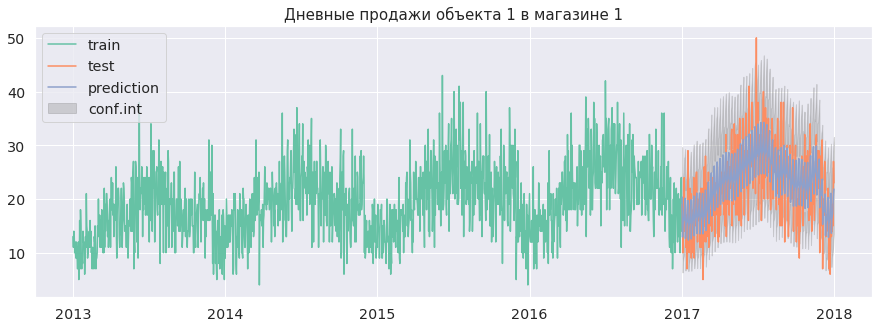

In [ ]:
prophet_boxcox_prediction = y_prophet_boxcox_forecast['yhat']
plot_results(data_train, data_test, prophet_boxcox_prediction, plot_conf_int=True,
             left_bound=y_prophet_boxcox_forecast['yhat_lower'],
             right_bound=y_prophet_boxcox_forecast['yhat_upper'])

Теперь сравним старые и новые результаты.

In [ ]:
add_results_in_comparison_table('Prophet + boxcox', data_test, prophet_boxcox_prediction)

,method,MSE,MAE,MAPE
0,Prophet,24.682585,4.032309,22.235187
1,Prophet + holidays,25.090789,4.074780,22.537087
2,Prophet + boxcox,24.065409,3.983335,21.640853


Видим, что результаты стали лучше.

Проверим теперь предсказательный интервал:

In [ ]:
check_predictive_interval(data_test, 
                          left_bound=y_prophet_boxcox_forecast['yhat_lower'],
                          right_bound=y_prophet_boxcox_forecast['yhat_upper'])

Pct. of errors: 0.071,           left bound: 0.049, status: OK


Отлично, мы разобрались с Prophet, перейдем к другим моделям.

### 5. Auto Arima

Посмотрим, как будет предсказывать модель, полученная через `auto_arima`.

Для начала обучим модель.

In [ ]:
arima_model = auto_arima(data_train, seasonal=True, m=7)

Получим предсказания:

In [ ]:
y_arima_forecast, conf_int = arima_model.predict(
    n_periods=365, return_conf_int=True, alpha=0.05
)

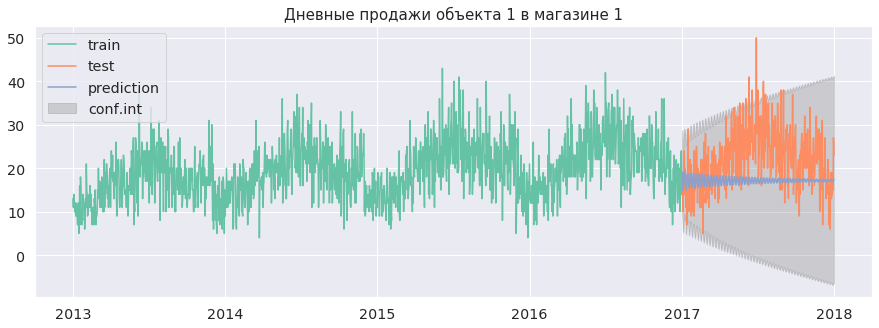

In [ ]:
plot_results(data_train, data_test, y_arima_forecast, plot_conf_int=True,
             left_bound=conf_int.T[0],
             right_bound=conf_int.T[1])

Как видно, модель не выучила годовую сезонность, что логично, так как она о ней ничего не знала. Использовать же в качестве периода 365 дней плоха идея, потому что:
- будет очень долго обучаться с очень большими вычислениями;
- может легко привести к переобучению, так как модель будет смотреть на большое число значений назад.

Посмотрим теперь на качество:

In [ ]:
add_results_in_comparison_table('Auto Arima model', data_test, y_arima_forecast)

,method,MSE,MAE,MAPE
0,Prophet,24.682585,4.032309,22.235187
1,Prophet + holidays,25.090789,4.074780,22.537087
2,Prophet + boxcox,24.065409,3.983335,21.640853
3,Auto Arima model,72.097614,6.688508,29.107256


Качество наихудшее среди всех моделей.

Посмотрим теперь, насколько хорош предсказательный интервал:

In [ ]:
check_predictive_interval(data_test, 
                          left_bound=conf_int.T[0],
                          right_bound=conf_int.T[1])

Pct. of errors: 0.036,           left bound: 0.021, status: OK


Видно, что предсказательный интервал прошел сейчас по границе.

-----

Теперь попробуем учесть годовую сезонность через экзогенные признаки, а точнее через ряды Фурье.

Будем рассматривать разложение в ряд Фурье до $K = 2$ первых слагаемых. На практике $K$ надо также перебирать, как и $p, d, q, P, D, Q$ в SARIMAX, оптимизируя один из информационнных критериев.

In [ ]:
exog = pd.DataFrame({'date': data.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))

# первые слагаемые в ряде Фурье
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)

# вторые слагаемые в ряде Фурье, поэтому вместо 2pi -> 4pi
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)
exog = exog.drop(columns=['date'])


exog_to_train = exog.iloc[:-365]
exog_to_test = exog.iloc[-365:]

Причем период сезонности равнен 365.25, так как через каждые 4 года в году 366 дней.

Обучим новую Auto Arima модель, используя эти экзогенные признаки:

In [ ]:
arima_exog_model = auto_arima(y=data_train, exogenous=exog_to_train, seasonal=True, m=7)
y_arima_exog_forecast, conf_int_exog = arima_exog_model.predict(
    n_periods=365, 
    exogenous=exog_to_test,
    return_conf_int=True, 
    alpha=0.05
)

Посмотрим на полученные предсказания.

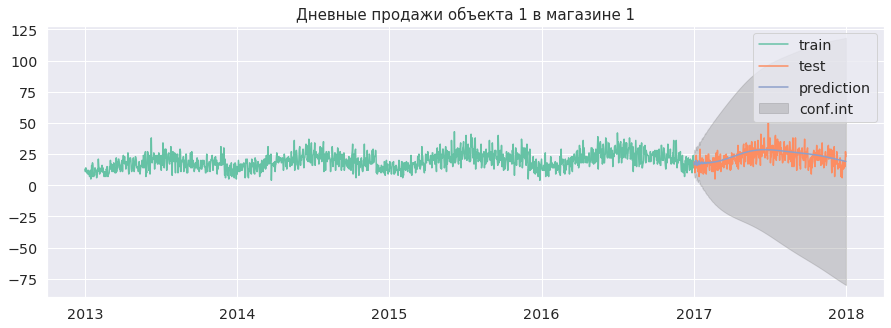

In [ ]:
plot_results(data_train, data_test, y_arima_exog_forecast, plot_conf_int=True,
             left_bound=conf_int_exog.T[0],
             right_bound=conf_int_exog.T[1])

In [ ]:
add_results_in_comparison_table('Auto Arima model with Fourier exog', 
                                data_test, y_arima_exog_forecast)

,method,MSE,MAE,MAPE
0,Prophet,24.682585,4.032309,22.235187
1,Prophet + holidays,25.090789,4.074780,22.537087
2,Prophet + boxcox,24.065409,3.983335,21.640853
3,Auto Arima model,72.097614,6.688508,29.107256
4,Auto Arima model with Fourier exog,34.980364,4.742038,27.022426


Видно, что качество модели сильно возросло по сравнению с обычной ARIMA моделью, но все еще хуже чем остальные методы.

In [ ]:
check_predictive_interval(data_test, 
                          left_bound=conf_int_exog.T[0],
                          right_bound=conf_int_exog.T[1])

Pct. of errors: 0.0,           left bound: 0.0, status: OK


Зато предсказательный интервал в этот раз точно корректен.

-----

### 6. TBATS

Теперь посмотрим на модель, которая была специально построена, чтобы учитывать несколько сезонностей.


`class` <a href="https://pypi.org/project/tbats/#description">`tbats.TBATS`</a>`(use_box_cox=None, box_cox_bounds=(0, 1), use_trend=None, use_damped_trend=None, seasonal_periods=None, use_arma_errors=True, show_warnings=True, n_jobs=None, multiprocessing_start_method='spawn', context=None)`

Параметры:

* `use_box_cox` &mdash;использовать или нет преобразование Бокса-Кокса;
* `box_cox_bounds` &mdash;минимальное и макисимальное значение $\lambda$ в преобразовании;
* `use_trend` &mdash;использовать или нет тренд;
* `use_damped_trend` &mdash;должен ли тренд уменьшаться со временем или нет;
* `seasonal_periods` &mdash;список с периодами сезонности;
* `n_jobs` &mdash;количество ядер.

Все параметры `None` подбираются автоматически, оптимизируя информационный критерий AIC.

__Недостаток модели:__

Она не может использовать никакие внешние факторы, к примеру, информацию о праздниках.


---

Передадим модели недельную и годовую сезонность и обучим ее.

In [ ]:
tbats_estimator = TBATS(seasonal_periods=(7, 365.25), n_jobs=20)
model = tbats_estimator.fit(data_train)

Посмотрим на параметры оптимальной модели:

In [ ]:
print(model.summary())

Use Box-Cox: True
Use trend: False
Use damped trend: False
Seasonal periods: [  7.   365.25]
Seasonal harmonics [ 3 11]
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.234955
Smoothing (Alpha): 0.015789
Seasonal Parameters (Gamma): [ 8.43667263e-04  1.61227440e-03 -1.80755703e-03 -1.37450474e-05]
AR coefficients []
MA coefficients []
Seed vector [ 3.81313824e+00 -2.74645415e-01 -1.69626587e-02  1.26129302e-01
 -5.67941864e-02  1.86125556e-01  1.01120904e-01 -5.00481084e-01
 -5.29879742e-02 -1.14033714e-01 -5.71844500e-03 -4.67508703e-02
  2.10869447e-05  3.17363653e-02  2.56748598e-02  4.95179412e-02
  3.09192993e-02  3.19082012e-02 -6.20531138e-02 -1.00282034e-01
 -7.52737801e-02  2.34408825e-02  6.82536086e-02  7.30941114e-02
  9.59125330e-03  1.53375541e-02 -1.72073271e-02 -3.43625403e-02
 -4.08392956e-03]

AIC 14974.983349


Видно, что
- ARMA коэффициенты равны 0;
- тренда модель не нашла;
- модель посчитала важным использовать преобразование Бокса-Кокса.

Теперь построим предсказания на год вперед.

In [ ]:
tbats_forecast, confidence_info = model.forecast(steps=365, confidence_level=0.95)

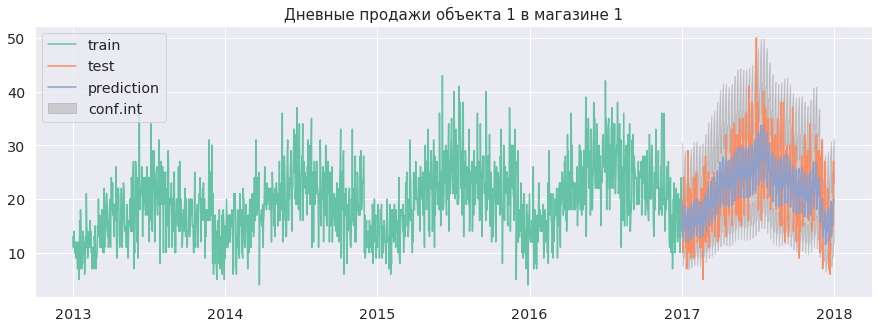

In [ ]:
plot_results(data_train, data_test, tbats_forecast, plot_conf_int=True,
             left_bound=confidence_info['lower_bound'],
             right_bound=confidence_info['upper_bound'])

Посмотрим на результаты сравнения по метрике:

In [ ]:
add_results_in_comparison_table('TBATS model', data_test, tbats_forecast)

,method,MSE,MAE,MAPE
0,Prophet,24.682585,4.032309,22.235187
1,Prophet + holidays,25.090789,4.074780,22.537087
2,Prophet + boxcox,24.065409,3.983335,21.640853
3,Auto Arima model,72.097614,6.688508,29.107256
4,Auto Arima model with Fourier exog,34.980364,4.742038,27.022426
5,TBATS model,23.637445,3.857729,19.791148


TBATS побил все предыдущие модели по качеству по всем 3 метрикам.

Посмотрим теперь на предсказательный интервал:

In [ ]:
check_predictive_interval(data_test, 
                          left_bound=confidence_info['lower_bound'],
                          right_bound=confidence_info['upper_bound'])

Pct. of errors: 0.047,           left bound: 0.029, status: OK


Видно, что процент ошибок примерно 5%, а значит предсказательный интервал у модели корректен.

----
# Итого

В данном нотубуке было рассмотрено, как работать со следующими моделями:

- Prophet;
- auto arima с экзогенными факторами для учета нескольких сезонностей;
- TBATS модель.

На данном датасете лучше всего себя показала TBATS модель, но в других случаях, когда есть экзогенные факторы, остальные модели могут получить качество лучше.